In [90]:
chans = 2
num_pool_layers = 4
kernels = [
    chans * 2 ** layer for layer in range(num_pool_layers + 1)
]
kernels

[2, 4, 8, 16, 32]

\begin{equation}
\lambda_k(t) := \frac{ \mathrm{exp}( \ w_k(t - 1) \ )}{\sum_i \mathrm{exp}( \ w_i(t - 1) \ )} \ , \ w_k(t - 1) = \frac{\mathcal{L}_k(t - 1)}{\mathcal{L}_k(t - 2)}
\end{equation}

In [92]:
for layer in reversed(range(1, num_pool_layers)):
    print (layer)

3
2
1


In [79]:
df = pd.read_csv('plots/best/summary_div_coronal_pd.csv')

In [80]:
df = df.drop('Unnamed: 0', axis = 1)
df = df.sort_values(by=[f'div_coronal_pd'])

In [81]:
df

loss   ssim  psnr  nrmse  div_coronal_pd_fs  div_coronal_pd  lossname  \
0   NaN  0.903   NaN    NaN           0.064386             1.0       NaN   
1   NaN  0.903   NaN    NaN           0.215292             1.0       NaN   
2   NaN  0.904   NaN    NaN           0.509054             1.0       NaN   
3   NaN  0.905   NaN    NaN           1.000000             1.0       NaN   

  ssimname  psnrname  nrmsename  
0    dwa10       NaN        NaN  
1    dwa10       NaN        NaN  
2   naive2       NaN        NaN  
3   naive2       NaN        NaN

In [86]:
not df['nrmsename'].isnull().values.any()

False

In [26]:
import os
import torch.nn as nn
import numpy as np
from dloader import genDataLoader 
import sigpy as sp
import sigpy.plot as pl
from fastmri.data import transforms
from collections import Counter
import pandas as pd
import torch
from fastmri_varnet import NormUnet
from utils import Module_Hook

class MTL_VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """

    def __init__(
        self,
        chans: int = 18,
        pools: int = 4,
    ):
        super().__init__()
        self.trueshare = nn.ModuleList()

        for i in range(1):
            self.trueshare.add_module(
                f'share_{i}',
                NormUnet(chans, pools, which_unet = 'MHUnet', contrast_count = 2),
            )
    def get_modules(self):
        return self.named_modules()
    def forward(self, image):
        for block in self.trueshare:
            image = block(image)
        return image

In [29]:
mynet = MTL_VarNet()

In [37]:
mynet.modules

<bound method Module.modules of MTL_VarNet(
  (trueshare): ModuleList(
    (share_0): NormUnet(
      (unet): MHUnet(
        (down_sample_layers): ModuleList(
          (shared_0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(2, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): InstanceNorm2d(18, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): Dropout2d(p=0.0, inplace=False)
              (4): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): InstanceNorm2d(18, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (6): LeakyReLU(negative_slope=0.2, inplace=True)
              (7): Dropout2d(p=0.0, inplace=False)
            )
          )
          (shared_1): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(18, 36, kernel_size=(3, 3

In [41]:
it = 0
structures = [
    nn.ModuleList, 
    nn.Sequential,
]
hooks = []

for name, module in mynet.get_modules():
    print(id(module), name)
    module.double
    create_hook = True
    
    if 'fastmri' in str(type(module)) or 'MTL' in str(type(module)):
        create_hook = False
    for structure in [nn.ModuleList, nn.Sequential]:
        if type(module) == structure:
            create_hook = False
            
    if create_hook:
        if 'decoder' in name:
            accumulated_by = int(name.split('decoder_')[1][0])
        else:
            accumulated_by = 2
        
        hooks.append((
            Module_Hook(
            module,
            f'hook_{name}',
            accumulated_by = accumulated_by
            ),
            name
        ))
    it += 1

140174019053552 
140174019054752 trueshare
140174019055184 trueshare.share_0
140174019055136 trueshare.share_0.unet
140174019051824 trueshare.share_0.unet.down_sample_layers
140174019053504 trueshare.share_0.unet.down_sample_layers.shared_0
140174019052592 trueshare.share_0.unet.down_sample_layers.shared_0.layers
140174019054224 trueshare.share_0.unet.down_sample_layers.shared_0.layers.0
140174019054128 trueshare.share_0.unet.down_sample_layers.shared_0.layers.1
140174029515984 trueshare.share_0.unet.down_sample_layers.shared_0.layers.2
140174019100832 trueshare.share_0.unet.down_sample_layers.shared_0.layers.3
140174019101072 trueshare.share_0.unet.down_sample_layers.shared_0.layers.4
140174026783856 trueshare.share_0.unet.down_sample_layers.shared_0.layers.5
140174028252544 trueshare.share_0.unet.down_sample_layers.shared_0.layers.6
140174019052544 trueshare.share_0.unet.down_sample_layers.shared_0.layers.7
140174019052688 trueshare.share_0.unet.down_sample_layers.shared_1
1401740191

In [44]:
id(mynet.trueshare.share_0.unet.down_sample_layers)
# 140174019051824

140174019051824

In [142]:
summary_file = os.path.join(
    '~/../../mnt/dense/vliu/models',
    'MTL_naive2_varnetIIVVVVVVVVVV_div_coronal_pd_fs_div_coronal_pd/summary_div_coronal_pd.csv',
)

In [145]:
pd.read_csv(summary_file).drop('Unnamed: 0', axis = 1)

loss      ssim       psnr     nrmse  div_coronal_pd_fs  div_coronal_pd
0  0.020023  0.893604  33.769899  0.083063           0.076459             1.0
1  0.019997  0.893697  33.831103  0.082426           0.233400             1.0

In [132]:
dictionary = nn.ModuleDict({
    'conv' : nn.Conv2d(10, 10, 3),
    'pool' : c,
    'try' : a,
})

In [133]:
dictionary['try'].add_module(name = 'dictadd', module = b)

In [134]:
a

MaxPool2d(
  kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False
  (dictadd): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
)

In [129]:
dictionary

ModuleDict(
  (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): ModuleList(
    (0): MaxPool2d(
      kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False
      (hi): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
)

In [105]:
for module in list(dictionary.modules()):
    if not(isinstance(module, nn.ModuleDict) or isinstance(module, nn.ModuleList)):
        print(module)

Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [77]:
a = [1, 2]
b = [3, 4]
for i, (j, k) in enumerate(zip(a, b)):
    print(i, j)

0 1
1 2


In [19]:
datasets = [
    'div_coronal_pd_fs',
    'div_coronal_pd'
]

datadir = '/mnt/dense/vliu/summer_dset/'

In [20]:
basedirs = [
    os.path.join(datadir, dataset)
    for dataset in datasets
]

In [25]:
train_dloader = genDataLoader(
    [f'{basedir}/Test' for basedir in basedirs],
    [4, 0], # downsample
    center_fractions = [0.06],
    accelerations = [6],
    num_workers= 16,
    shuffle = True,
    stratified = 1, method = 'upsample'
)

In [27]:
dloader = iter(train_dloader[0])

[ 22  58  13  77  28 176  27 122  17 132  34 168   3  88  29  86   3 175
  10  51   9 145   8 113  15 112   2  80  26  59  22 141  10  47  21 110
   7  92  21 150  30  87   5  57   0  61  35 149   4 138   7 107  24 157
   9  46  30 118  19 169  13 123  23  99  27 167  33 142  33  95  18  98
  12 126   3 158  15  91  30 151  22 135   5  82  28 129  11  74   1  48
  34 178   4 163  29 153  34  73  27 154  10  49  13 162  29 179  18 160
  21 134   3  36   6  78  23 155  20  70  34  67   4  63  13  40   2  93
  27  85  28 114  24 143  26 170  31 139  27 159  15  94   1 174  25 156
  32 127   5  37  25 146  16 136  30 121  14 172  14  90  24  83  28 148
  20 102  35  89  17 152  11 111   8 130  16  50  17  76  11 117  17  55
  29 119  22  64  35  53   2 108  32  56  17 166  10  60  32 116  30 131
  35  75   3  72   0  79  21 133  16 171   0 106  34  44   6 140   1 137
   8 103   5  71   1 128  24 120  20 115  26  97   0  52  16  54  18 180
  21  42   7  84  12  81  20 100   4  41  13 173  1

In [28]:
train_dloader[1]

{'div_coronal_pd_fs': 145, 'div_coronal_pd': 145}

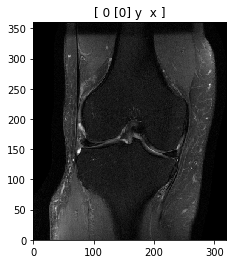

('div_coronal_pd_fs',)


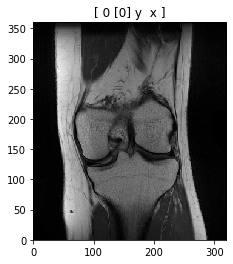

('div_coronal_pd',)


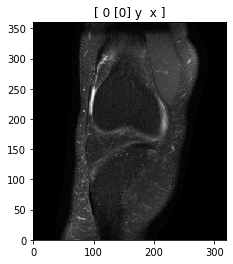

('div_coronal_pd_fs',)


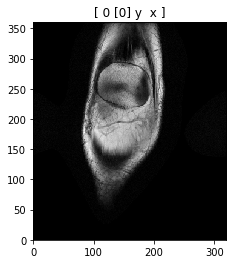

('div_coronal_pd',)


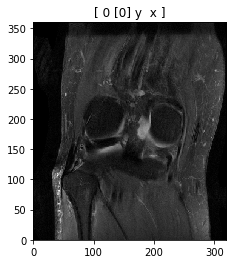

('div_coronal_pd_fs',)


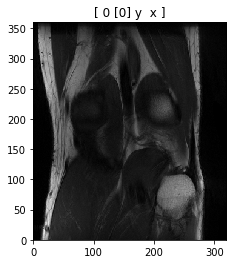

('div_coronal_pd',)


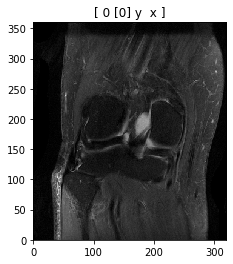

('div_coronal_pd_fs',)


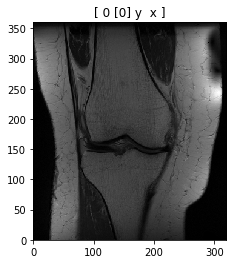

('div_coronal_pd',)


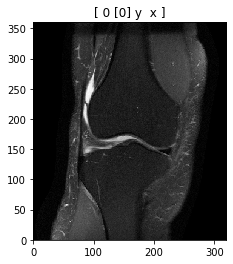

('div_coronal_pd_fs',)


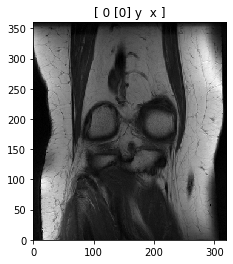

('div_coronal_pd',)


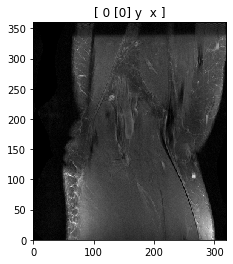

('div_coronal_pd_fs',)


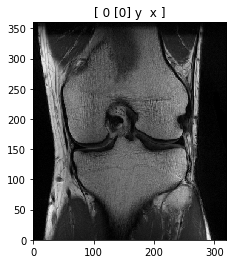

('div_coronal_pd',)


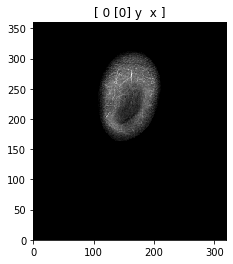

('div_coronal_pd_fs',)


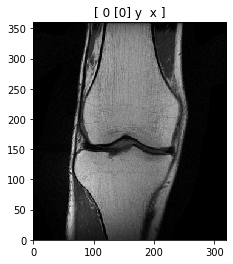

('div_coronal_pd',)


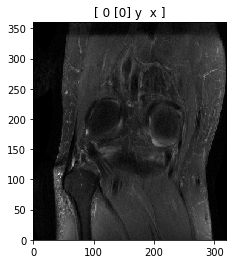

('div_coronal_pd_fs',)


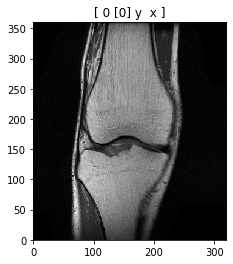

('div_coronal_pd',)


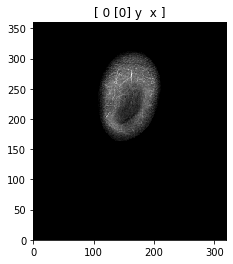

('div_coronal_pd_fs',)


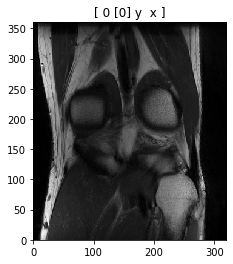

('div_coronal_pd',)


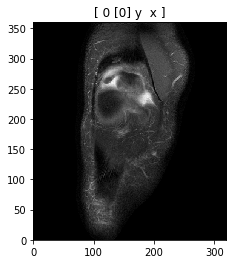

('div_coronal_pd_fs',)


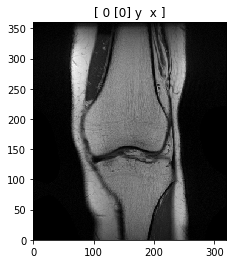

('div_coronal_pd',)


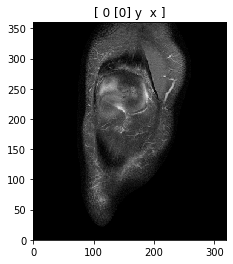

('div_coronal_pd_fs',)


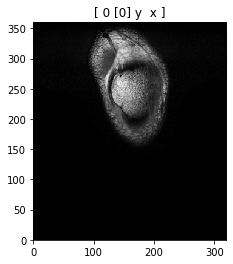

('div_coronal_pd',)


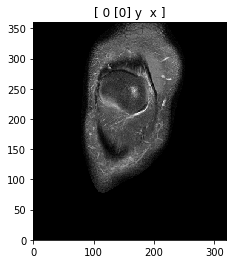

('div_coronal_pd_fs',)


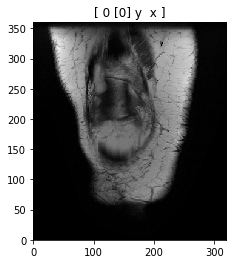

('div_coronal_pd',)


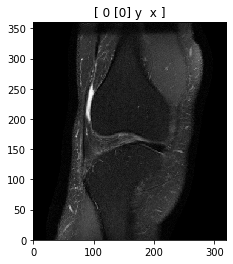

('div_coronal_pd_fs',)


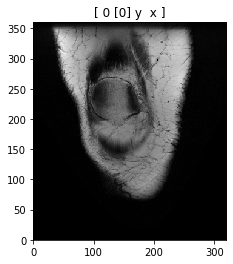

('div_coronal_pd',)


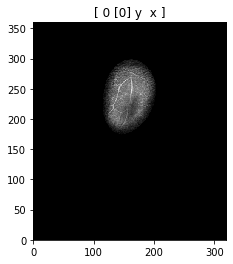

('div_coronal_pd_fs',)


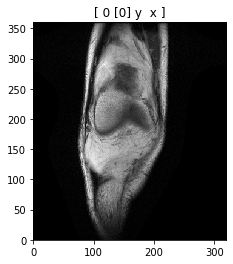

('div_coronal_pd',)


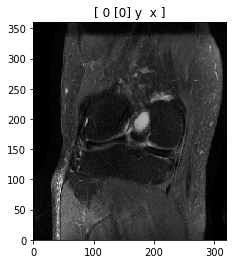

('div_coronal_pd_fs',)


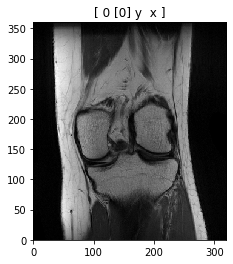

('div_coronal_pd',)


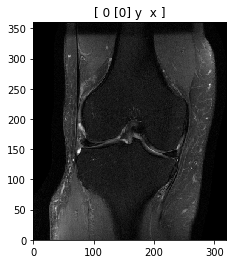

('div_coronal_pd_fs',)


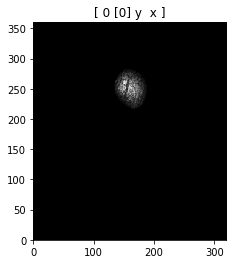

('div_coronal_pd',)


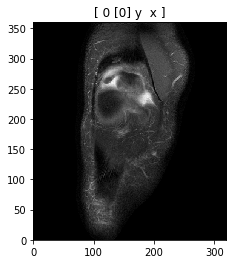

('div_coronal_pd_fs',)


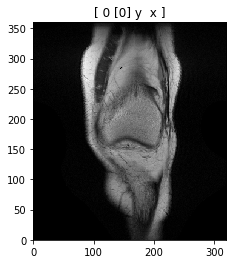

('div_coronal_pd',)


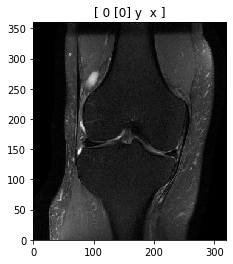

('div_coronal_pd_fs',)


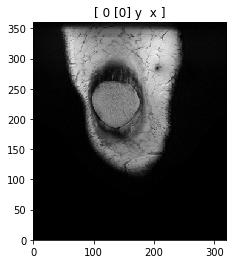

('div_coronal_pd',)


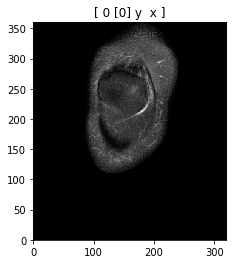

('div_coronal_pd_fs',)


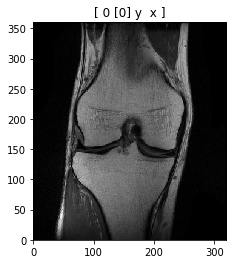

('div_coronal_pd',)


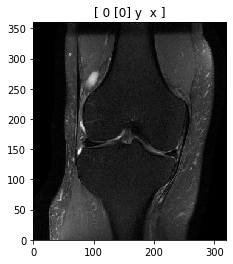

('div_coronal_pd_fs',)


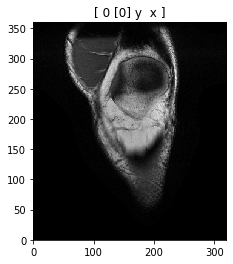

('div_coronal_pd',)


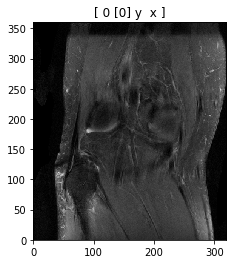

('div_coronal_pd_fs',)


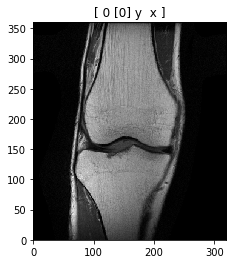

('div_coronal_pd',)


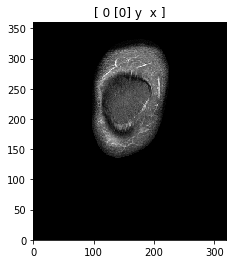

('div_coronal_pd_fs',)


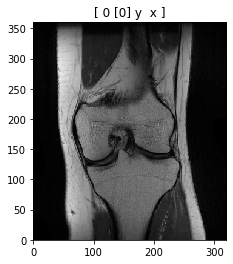

('div_coronal_pd',)


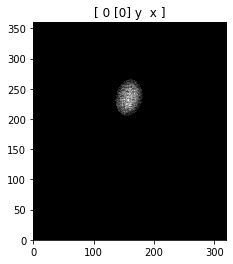

('div_coronal_pd_fs',)


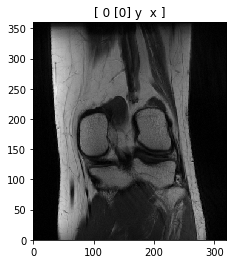

('div_coronal_pd',)


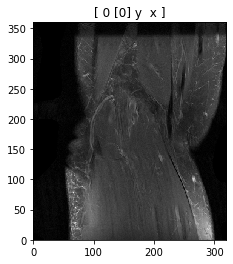

('div_coronal_pd_fs',)


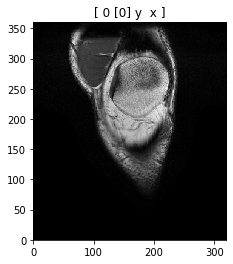

('div_coronal_pd',)


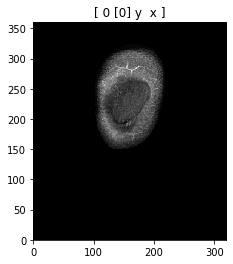

('div_coronal_pd_fs',)


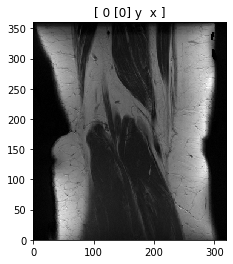

('div_coronal_pd',)


KeyboardInterrupt: 

In [29]:
for kspace, mask, esp, im_fs, contrast in dloader:
    im_fs = transforms.tensor_to_complex_np(im_fs)
    pl.ImagePlot(im_fs) # this is true image
    print(contrast)

In [59]:
default=[
    'trueshare', 'mhushare', 'trueshare', 'mhushare',
    'trueshare', 'split', 'trueshare', 'split',
    'trueshare', 'split', 'trueshare', 'split',
]

In [57]:
a = Counter(default)

In [54]:
for structure in default:
    assert structure in ['trueshare', 'mhushare', 'split'], \
           f'{structure} is not a supported block structure'

In [58]:
a['trueshare']

6

In [60]:
a = iter(default)

In [63]:
next(a) = 'lol'

SyntaxError: cannot assign to function call (<ipython-input-63-3f406cbc1200>, line 1)

In [64]:
for i in default:
    i = 1

In [65]:
default

['trueshare',
 'mhushare',
 'trueshare',
 'mhushare',
 'trueshare',
 'split',
 'trueshare',
 'split',
 'trueshare',
 'split',
 'trueshare',
 'split']